# Classification Alogrithms and API in Scikit Learn
- Theory part first
- Code part starts after theory

## Ridge Classifier

### Binary Class
- RidgeClassifier is a classifier variant of the Ridge regressor.
- classifier first converts binary targets to {-1, 1} and then treats the problem as a regression task, optimizing the objective of regressor.

### Multiclass classification:

- treated as multi-output regression
- predicted class corresponds to the output with the highest value

### How to train a least square classifier?

In [2]:
from sklearn.linear_model import RidgeClassifier
rc = RidgeClassifier()
# rc.fit(X_train, y_train)

### How to set regularization rate in RidgeClassifier?

In [3]:
rc = RidgeClassifier(alpha=0.1)

### How to solve optimization problem in RidgeClassifier?

- svd
- cholesky
- sparse_cg - for large scale data, use 'sparse_eg ' solver.
- lsqr
- sag, saga : When both n_samples and _features are large, use 'sag' or 'saga solvers.
- lbfsg
- `solver=auto` will set solver automatically

## Perceptron Classifier

### How to implement?

In [4]:
from sklearn.linear_model import Perceptron
pm = Perceptron()

### Set penalaties

In [5]:
pm = Perceptron(penalty='l1', early_stopping=True, fit_intercept=False, 
                max_iter=50, n_iter_no_change=5, tol=1e-3, eta0=1, validation_fraction=0.1)

- Perceptron classifier can be trained in an iterative manner with `partial_fit` method
- Perceptron classifier can be initialized to the weights of the previous run by specifying `warm_start = True` in the constructor.

## Logistic Regression

In [6]:
from sklearn.linear_model import LogisticRegression
logit_classifier = LogisticRegression()

In [7]:
# X_train, y_train = [], []
# logit_classifier.fit()

### Solver for Logistic Regression

In [8]:
solver = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
logit_classifier = LogisticRegression(solver= 'lbfgs')

- For small datasets, `'liblinear'` is a good choice, whereas `'sag'` and '`saga'` are faster for large ones.
- For unscaled datasets, `'liblinear'`, `'Ibfgs'` and `'newton-cg'` are robust.
- For multiclass problems, only `'newton-cg'`, `'sag'`, `'saga'` and `'Ibfgs'` handle multinomial loss.
- `'liblinear'` is limited to one-versus-rest schemes

# -----------------------------------------------------------------------

# (Code) Binary class IMAGE CLASSIFICATION using Perceptron

## Imports

In [9]:
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import Perceptron
from sklearn.metrics import hinge_loss, ConfusionMatrixDisplay, confusion_matrix, precision_recall_curve, precision_score, recall_score
from sklearn.metrics import classification_report, make_scorer
from sklearn.model_selection import cross_validate, cross_val_predict, GridSearchCV
from pprint import pprint
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#### MNIST dataset takes alot of time to get downloaded so I will download it from kaggle

In [10]:
# from sklearn.datasets import fetch_openml

# X, y = fetch_openml(
#     name="mnist_784",
#     version=1,
#     as_frame=False,
#     parser = 'auto',
#     return_X_y=True
# )



In [11]:
data = pd.read_csv('mnist_784.csv')

In [12]:
X = data.loc[:, 'pixel1':'pixel784']
y = data['class']

## Data Spilitting and Loading

In [13]:
X = X.to_numpy()
y = y.to_numpy()

In [14]:
target_names = np.unique(y)
print('Number of samples: {0}, type:{1}'.format(X.shape[0], X.dtype))
print ('Number of features:{0}'.format(X.shape[1]))
print('Minimum :{0}, Maximum: {1}'.format(np.min(X), np.max(X)))
print (' Number of classes: {0}, type: {1}'. format(len(target_names), y.dtype))
print ('Labels: {0}'.format(target_names))

Number of samples: 70000, type:int64
Number of features:784
Minimum :0, Maximum: 255
 Number of classes: 10, type: int64
Labels: [0 1 2 3 4 5 6 7 8 9]


## Preprocessing

In [15]:
X = MinMaxScaler().fit_transform(X)
print("Minimum:{0}, Maximum:{1}".format(np.min(X), np.max(X)))

Minimum:0.0, Maximum:1.0


## Data Visualization

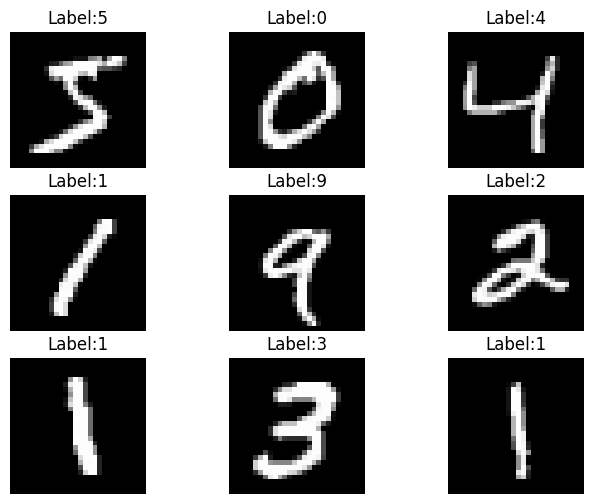

In [16]:
num_images = 9 #choose a square number
factor = int(np.sqrt(num_images))
fig, ax= plt.subplots(nrows=factor, ncols=factor, figsize = (8,6))
idx_offset = 0
for i in range(factor):
    index = idx_offset+i*(factor)
    for j in range(factor):
        ax[i,j].imshow(X[index+j].reshape(28,28), cmap= 'gray')
        ax[i,j].set_title('Label:{0}'.format(str(y[index+j])))
        ax[i,j].set_axis_off()

## Spilitting the Data

In [17]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

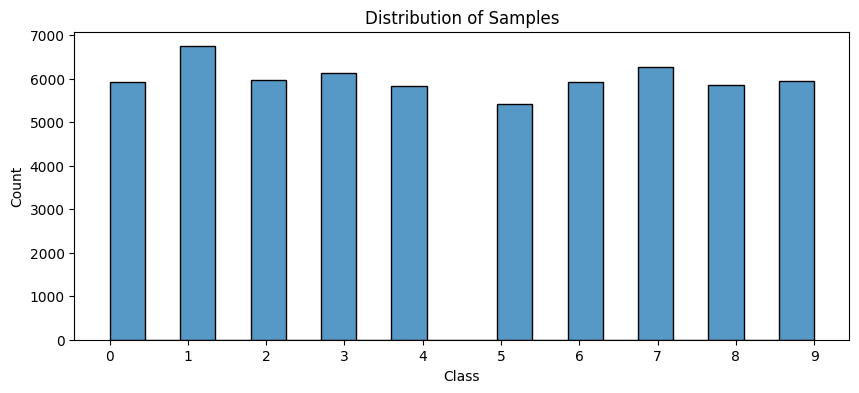

In [18]:
plt.figure(figsize=(10,4))
sns.histplot(data=np.int8(y_train),binwidth=0.45,bins=11)
plt.xticks(ticks=[0,1,2,3,4,5,6,7,8,9], labels=[0,1,2,3,4,5,6,7,8,9]) 
plt.xlabel('Class')
plt.title('Distribution of Samples')
plt.show()

## Binary Class (0-Detector)

In [19]:
y_train_0 = -1 * np.ones((len(y_train)))
y_test_0 = -1 * np.ones((len(y_test)))

#find all indices of 0 image
indx_0 = np.where(y_train==0)

y_train_0[indx_0] = 1
indx_0 = np.where(y_test==0)
y_test_0[indx_0] = 1

In [20]:
np.unique(y_train_0)

array([-1.,  1.])

## Baseline Model

In [21]:
num_pos = len(np.where(y_train == 1)[0])
num_neg = len(np.where(y_train == -1)[0])

In [22]:
base_clf = DummyClassifier(strategy="most_frequent")
base_clf.fit(X_train, y_train_0)

,strategy,'most_frequent'
,random_state,None
,constant,None


In [23]:
print('Training accuracy:{0:.2f}'.format(base_clf.score(X_train,y_train_0)))
print ('Testing accuracy:{0:.2f}'.format(base_clf.score(X_test,y_test_0)))

Training accuracy:0.90
Testing accuracy:0.90


## Perceptron Model

In [24]:
bin_clf = Perceptron(max_iter=100, random_state=19)

In [25]:
bin_clf.fit(X_train, y_train_0)
print('Dimention of Weights w:{0}'.format(bin_clf.coef_.shape))
print('Bias: {0}'.format(bin_clf.intercept_))
print("The loss function: {}".format("perceptron"))

Dimention of Weights w:(1, 784)
Bias: [-96.]
The loss function: perceptron


In [26]:
y_train_hat_0 = bin_clf.predict(X_train)
print(' Training Accuracy: ', bin_clf.score(X_train,y_train_0)) 

 Training Accuracy:  0.9923166666666666


In [27]:
print(' Training Accuracy: ', bin_clf.score(X_test,y_test_0))

 Training Accuracy:  0.9912


## Confusion Matrix

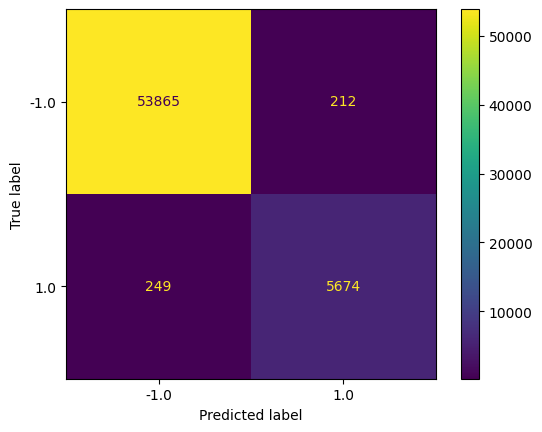

In [28]:
cm_display = ConfusionMatrixDisplay.from_predictions(y_train_0,y_train_hat_0, values_format='.5g')
plt.show()

In [29]:
cf_matrix = cm_display.confusion_matrix
tn = cf_matrix[0,0]
fn = cf_matrix[1,0]
fp = cf_matrix[0,1]
tp = cf_matrix[1,1]

precision = tp/(tp+fp)
print("Precision:", precision)
recall = tp/(tp+fn)
print("Recall:", recall)
accuracy = (tn+tp)/(tn+tp+fn+fp)
print('Accuracy', accuracy)

Precision: 0.963982330954808
Recall: 0.9579604929934155
Accuracy 0.9923166666666666


## Cross Validation

In [30]:
bin_clf = Perceptron(max_iter=100, random_state=19)
scores = cross_validate(bin_clf, X_train, y_train_0, cv=5, scoring=['precision', 'recall', 'f1'], return_estimator=True)
pprint(scores)

KeyboardInterrupt: 

In [ ]:
print(classification_report(y_train_0, y_train_hat_0))

              precision    recall  f1-score   support

        -1.0       1.00      1.00      1.00     54077
         1.0       0.96      0.96      0.96      5923

    accuracy                           0.99     60000
   macro avg       0.98      0.98      0.98     60000
weighted avg       0.99      0.99      0.99     60000



## Multi-Class Image

In [ ]:
from sklearn.preprocessing import LabelBinarizer

In [ ]:
clf = Perceptron()

In [ ]:
y_train_ovr = LabelBinarizer().fit_transform(y_train)
for i in range(10):
    print('{0}:{1}'.format(y_train[i],y_train_ovr[i]))

5:[0 0 0 0 0 1 0 0 0 0]
0:[1 0 0 0 0 0 0 0 0 0]
4:[0 0 0 0 1 0 0 0 0 0]
1:[0 1 0 0 0 0 0 0 0 0]
9:[0 0 0 0 0 0 0 0 0 1]
2:[0 0 1 0 0 0 0 0 0 0]
1:[0 1 0 0 0 0 0 0 0 0]
3:[0 0 0 1 0 0 0 0 0 0]
1:[0 1 0 0 0 0 0 0 0 0]
4:[0 0 0 0 1 0 0 0 0 0]


In [ ]:
clf.fit(X_train, y_train)

,penalty,None
,alpha,0.0001
,l1_ratio,0.15
,fit_intercept,True
,max_iter,1000
,tol,0.001
,shuffle,True
,verbose,0
,eta0,1.0
,n_jobs,None
,random_state,0


In [ ]:
print('Shape of weight matrix: {0} and bias vector:{1}'.format(clf.coef_.shape, clf.intercept_.shape))

Shape of weight matrix: (10, 784) and bias vector:(10,)


In [ ]:
scores = clf.decision_function(X_train[6].reshape(1,-1))
print(scores)
print(' The predicted class: ', np.argmax(scores))

[[-595.37464052  140.54051519 -103.43693964    3.02414456 -262.5048366
  -154.68861207 -130.299208   -194.27973856  -86.55655517 -182.65497885]]
 The predicted class:  1


In [ ]:
y_hat = clf.predict(X_train)

In [ ]:
print(classification_report(y_train, y_hat))

              precision    recall  f1-score   support

           0       0.97      0.95      0.96      5923
           1       0.95      0.98      0.96      6742
           2       0.93      0.87      0.90      5958
           3       0.75      0.92      0.82      6131
           4       0.90      0.93      0.92      5842
           5       0.79      0.89      0.84      5421
           6       0.95      0.95      0.95      5918
           7       0.86      0.95      0.90      6265
           8       0.88      0.75      0.81      5851
           9       0.96      0.68      0.79      5949

    accuracy                           0.89     60000
   macro avg       0.89      0.89      0.88     60000
weighted avg       0.89      0.89      0.89     60000



### Let's create a confusion matrix

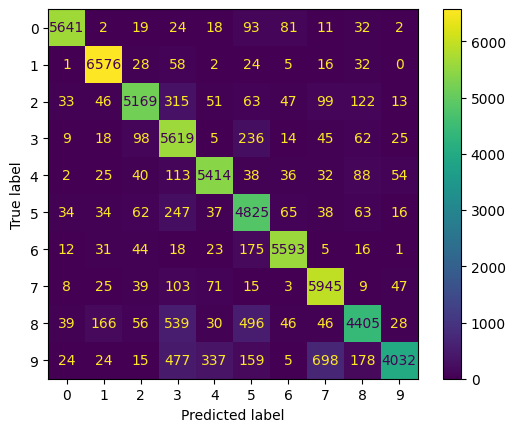

In [ ]:
cm_display = ConfusionMatrixDisplay.from_predictions(y_train, y_hat, values_format='.5g')

In [ ]:
## Creating a Pipeline

In [ ]:
pipe = Pipeline([ ('std_scaler', MinMaxScaler()),
                       ('bin_clf', Perceptron())])

In [ ]:
pipe.fit(X_train, y_train_0)

,steps,"[('std_scaler', ...), ('bin_clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,feature_range,"(0, ...)"
,copy,True
,clip,False
,penalty,None
,alpha,0.0001
,l1_ratio,0.15
,fit_intercept,True


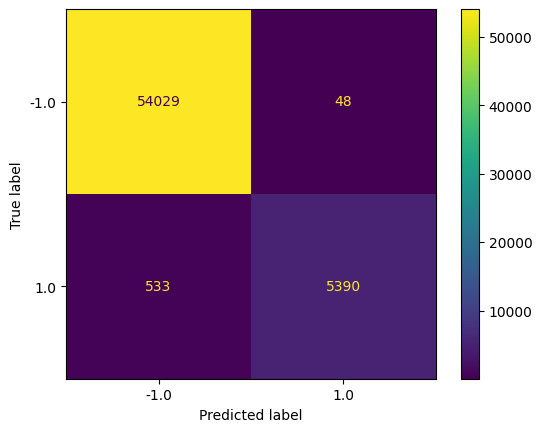

In [ ]:
y_train_hat_0 = pipe.predict(X_train)

cm_display = ConfusionMatrixDisplay.from_predictions(y_train_0, y_train_hat_0, values_format='0.5g')

## Iteration vs Loss Curve

In [ ]:
iterations = 100
bin_clf1 = Perceptron(max_iter=1000, random_state=1000)
Loss_clf = []
for i in range(iterations):
    bin_clf1.partial_fit(X_train, y_train_0, classes=np.array([1,-1]))
    y_hat_0 = bin_clf1.decision_function(X_train)
    Loss_clf.append(hinge_loss(y_train_0, y_hat_0))

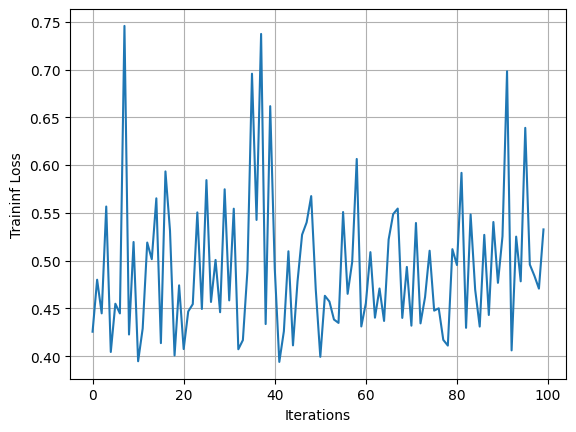

In [ ]:
plt.figure
plt.plot(np.arange(iterations), Loss_clf)
plt.grid(True)
plt.xlabel('Iterations')
plt.ylabel('Traininf Loss')
plt.show()

## GridSeach for Hyper Tuning

In [ ]:
scoring = make_scorer(hinge_loss, greater_is_better=False)
lr_grid = [1/2**n for n in range(1,6)]
bin_clf_gscv = GridSearchCV(Perceptron(), param_grid={'eta0':lr_grid}, scoring=scoring, cv=5)
bin_clf_gscv.fit(X_train,y_train_0)

,estimator,Perceptron()
,param_grid,"{'eta0': [0.5, 0.25, ...]}"
,scoring,make_scorer(h...hod='predict')
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,penalty,None


In [ ]:
pprint(bin_clf_gscv.cv_results_)

{'mean_fit_time': array([0.64435697, 0.63863301, 0.60207033, 0.502281  , 0.46280155]),
 'mean_score_time': array([0.0058928 , 0.00554132, 0.0054966 , 0.00549827, 0.00540743]),
 'mean_test_score': array([-0.0285    , -0.0285    , -0.02643333, -0.03066667, -0.0421    ]),
 'param_eta0': masked_array(data=[0.5, 0.25, 0.125, 0.0625, 0.03125],
             mask=[False, False, False, False, False],
       fill_value=1e+20),
 'params': [{'eta0': 0.5},
            {'eta0': 0.25},
            {'eta0': 0.125},
            {'eta0': 0.0625},
            {'eta0': 0.03125}],
 'rank_test_score': array([2, 2, 1, 4, 5], dtype=int32),
 'split0_test_score': array([-0.02166667, -0.02166667, -0.02166667, -0.02166667, -0.02166667]),
 'split1_test_score': array([-0.0395, -0.0395, -0.0395, -0.0395, -0.0395]),
 'split2_test_score': array([-0.02816667, -0.02816667, -0.02816667, -0.02816667, -0.02816667]),
 'split3_test_score': array([-0.023     , -0.023     , -0.023     , -0.04416667, -0.04416667]),
 'split4_tes

# SGDRegressor for MNIST

In [ ]:
np.random.seed(306)

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import SGDClassifier, LogisticRegression, RidgeClassifier
from sklearn.model_selection import RandomizedSearchCV, cross_val_predict, cross_validate
from sklearn.metrics import log_loss, roc_auc_score, roc_curve

from scipy.stats import loguniform
import matplotlib as mpl
import seaborn as sns

In [ ]:
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
mpl.rc('figure',figsize=(8,6))

In [ ]:
def warn(*args, **kwargs):
    pass

import warnings
warnings.warn = warn

## Handwritten Digit Classification

In [ ]:
X_pd = data.loc[:, 'pixel1':'pixel784']
y_pd = data['class']

In [ ]:
X = X_pd.to_numpy()
y = y_pd.to_numpy()

## Preprocess

In [ ]:
scale = MinMaxScaler()
X = scale.fit_transform(X)

In [ ]:
y_train_0 = -1 * np.ones((len(y_train)))
y_test_0 = -1 * np.ones((len(y_test)))

#find all indices of 0 image
indx_0 = np.where(y_train==0)

y_train_0[indx_0] = 1
indx_0 = np.where(y_test==0)
y_test_0[indx_0] = 1

## Logistic Regression (sgd)

In [ ]:
bin_sgd_clf = SGDClassifier(loss='log_loss', penalty='l2', max_iter=1, warm_start=True, eta0=0.01,
                            alpha=0, learning_rate='constant', random_state=42)

Loss = []
iterations = 100

for i in range(iterations):
    bin_sgd_clf.fit(X_train, y_train_0)
    y_pred = bin_sgd_clf.predict_proba(X_train)
    Loss.append(log_loss(y_train_0, y_pred))

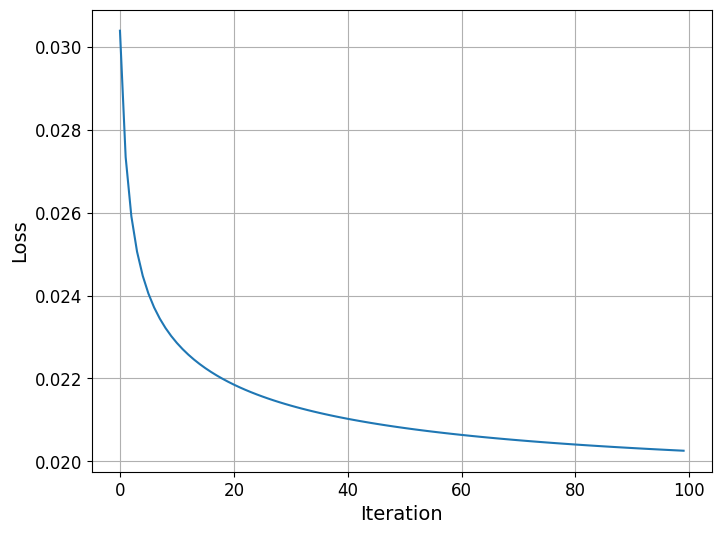

In [ ]:
plt.figure()
plt.plot (np.arange(iterations), Loss)
plt.grid (True)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

### With Cross-Validation

In [ ]:
estimator = SGDClassifier(loss='log_loss', penalty='l2', max_iter=100, eta0=0.01,
                            alpha=0, learning_rate='constant', random_state=42)

In [ ]:
cv_bin_clf = cross_validate(estimator, X_train, y_train_0, cv=5, scoring=['precision', 'recall', 'f1'], 
                            return_train_score=True, return_estimator=True)

pprint(cv_bin_clf)

{'estimator': [SGDClassifier(alpha=0, eta0=0.01, learning_rate='constant', loss='log_loss',
              max_iter=100, random_state=42),
               SGDClassifier(alpha=0, eta0=0.01, learning_rate='constant', loss='log_loss',
              max_iter=100, random_state=42),
               SGDClassifier(alpha=0, eta0=0.01, learning_rate='constant', loss='log_loss',
              max_iter=100, random_state=42),
               SGDClassifier(alpha=0, eta0=0.01, learning_rate='constant', loss='log_loss',
              max_iter=100, random_state=42),
               SGDClassifier(alpha=0, eta0=0.01, learning_rate='constant', loss='log_loss',
              max_iter=100, random_state=42)],
 'fit_time': array([0.90511417, 0.90031385, 0.89423203, 0.89391589, 0.89891887]),
 'score_time': array([0.01280689, 0.00817084, 0.00798488, 0.00782323, 0.00799799]),
 'test_f1': array([0.95784148, 0.95703956, 0.95930736, 0.9543497 , 0.96321642]),
 'test_precision': array([0.95622896, 0.96401028, 0.98488889, 

### Hyper Parameter tuning

In [ ]:
lr_grid = loguniform(1e-2, 1e-1) 

In [ ]:
estimator = SGDClassifier(loss='log_loss', penalty='l2', max_iter=1, eta0=0.01, warm_start=True,
                            alpha=0, learning_rate='constant', random_state=42)

In [ ]:
scores = RandomizedSearchCV(estimator, param_distributions={'eta0': lr_grid}, cv=5, scoring=['precision','recall','f1'],
                            n_iter=5, refit='f1')

In [ ]:
scores.fit(X_train, y_train_0)

,estimator,SGDClassifier...rm_start=True)
,param_distributions,{'eta0': <scipy.stats....t 0x11c537850>}
,n_iter,5
,scoring,"['precision', 'recall', ...]"
,n_jobs,None
,refit,'f1'
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,None
,error_score,nan


In [ ]:
pprint(scores.cv_results_)

{'mean_fit_time': array([0.17050171, 0.17245555, 0.1633718 , 0.16452589, 0.16602311]),
 'mean_score_time': array([0.00802774, 0.00803447, 0.00787859, 0.00791926, 0.00785303]),
 'mean_test_f1': array([0.94703567, 0.93301887, 0.94690444, 0.94528207, 0.93739479]),
 'mean_test_precision': array([0.98051466, 0.97507313, 0.98120244, 0.98047762, 0.97597786]),
 'mean_test_recall': array([0.91591729, 0.89565828, 0.91507313, 0.91271026, 0.9025804 ]),
 'param_eta0': masked_array(data=[0.019502241918923077, 0.09015577496802867,
                   0.021090244645099468, 0.030881795810903914,
                   0.07538370264235147],
             mask=[False, False, False, False, False],
       fill_value=1e+20),
 'params': [{'eta0': np.float64(0.019502241918923077)},
            {'eta0': np.float64(0.09015577496802867)},
            {'eta0': np.float64(0.021090244645099468)},
            {'eta0': np.float64(0.030881795810903914)},
            {'eta0': np.float64(0.07538370264235147)}],
 'rank_test_f1

In [ ]:
best_bin_clf = scores.best_estimator_

In [ ]:
y_hat_train_best_0 = best_bin_clf.predict(X_train)

In [ ]:
print(classification_report(y_train_0, y_hat_train_best_0))

              precision    recall  f1-score   support

        -1.0       0.99      1.00      1.00     54077
         1.0       0.98      0.93      0.95      5923

    accuracy                           0.99     60000
   macro avg       0.99      0.96      0.97     60000
weighted avg       0.99      0.99      0.99     60000



## Training Logistic Regression without Regularisation

In [ ]:
pipe_logit = make_pipeline(MinMaxScaler(), LogisticRegression(random_state=85, solver='lbfgs', C=np.inf))

In [ ]:
pipe_logit.fit(X_train, y_train_0)

,steps,"[('minmaxscaler', ...), ('logisticregression', ...)]"
,transform_input,None
,memory,None
,verbose,False
,feature_range,"(0, ...)"
,copy,True
,clip,False
,penalty,'l2'
,dual,False
,tol,0.0001
,C,inf


In [ ]:
grid_c = [0, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]
scaler = MinMaxScaler()
logreg = LogisticRegression(C=1.0, random_state=100)

pipe = Pipeline(steps=[
    ("scaler", scaler),
    ("logistic", logreg)
])

pipe_logit_cv = GridSearchCV(pipe, param_grid={"logistic__C": grid_c}, scoring='f1')

pipe_logit_cv.fit(X_train, y_train_0)

,estimator,Pipeline(step..._state=100))])
,param_grid,"{'logistic__C': [0, 0.0001, ...]}"
,scoring,'f1'
,n_jobs,None
,refit,True
,cv,None
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,feature_range,"(0, ...)"


In [ ]:
pipe_logit_cv.best_params_

{'logistic__C': 0.1}

In [ ]:
pipe_logit_cv.best_score_

np.float64(0.9582781080330685)

In [ ]:
pipe_logit_cv.best_estimator_

,steps,"[('scaler', ...), ('logistic', ...)]"
,transform_input,None
,memory,None
,verbose,False
,feature_range,"(0, ...)"
,copy,True
,clip,False
,penalty,'l2'
,dual,False
,tol,0.0001
,C,0.1


## Ridge Classifier

In [ ]:
estimator = RidgeClassifier(alpha=0)
pipe_ridge = make_pipeline(MinMaxScaler(), estimator)
pipe_ridge.fit(X_train, y_train_0)

,steps,"[('minmaxscaler', ...), ('ridgeclassifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,feature_range,"(0, ...)"
,copy,True
,clip,False
,alpha,0
,fit_intercept,True
,copy_X,True
,max_iter,None


In [ ]:
y_hat_test_0 = pipe_ridge.predict(X_test)
print(classification_report(y_test_0, y_hat_test_0))

              precision    recall  f1-score   support

        -1.0       0.99      0.99      0.99      9020
         1.0       0.94      0.86      0.90       980

    accuracy                           0.98     10000
   macro avg       0.96      0.93      0.94     10000
weighted avg       0.98      0.98      0.98     10000



### cross-validation

In [ ]:
cv_bin_ridge_clf = cross_validate(pipe_ridge, X_train, y_train_0, cv=5, scoring=['precision','f1', 'recall'], return_train_score=True, return_estimator=True)

In [ ]:
pprint(cv_bin_ridge_clf)

{'estimator': [Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('ridgeclassifier', RidgeClassifier(alpha=0))]),
               Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('ridgeclassifier', RidgeClassifier(alpha=0))]),
               Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('ridgeclassifier', RidgeClassifier(alpha=0))]),
               Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('ridgeclassifier', RidgeClassifier(alpha=0))]),
               Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('ridgeclassifier', RidgeClassifier(alpha=0))])],
 'fit_time': array([5.1611557 , 3.7796092 , 3.58097601, 3.63026214, 3.70905185]),
 'score_time': array([0.03916812, 0.03550577, 0.02450395, 0.02974296, 0.02388215]),
 'test_f1': array([0.79435484, 0.91092584, 0.92001768, 0.90547703, 0.89504771]),
 'test_precision': array([0.76003086, 0.94794521, 0.96567718, 0.94995366, 0.96948819]),
 'test_recall'

# MultiClass Classifier for MNIST

In [ ]:
estimator = SGDClassifier(loss='log_loss', penalty = 'l2', max_iter=1,
                     warm_start = True, eta0=0.01, alpha=0, learning_rate='constant', random_state=42)

pipe_sgd_over = make_pipeline(MinMaxScaler(), estimator)

In [ ]:
Loss = []
for i in range(iterations):
    pipe_sgd_over.fit(X_train, y_train)
    y_pred = pipe_sgd_over.predict_proba(X_train)
    Loss.append(log_loss(y_train, y_pred))

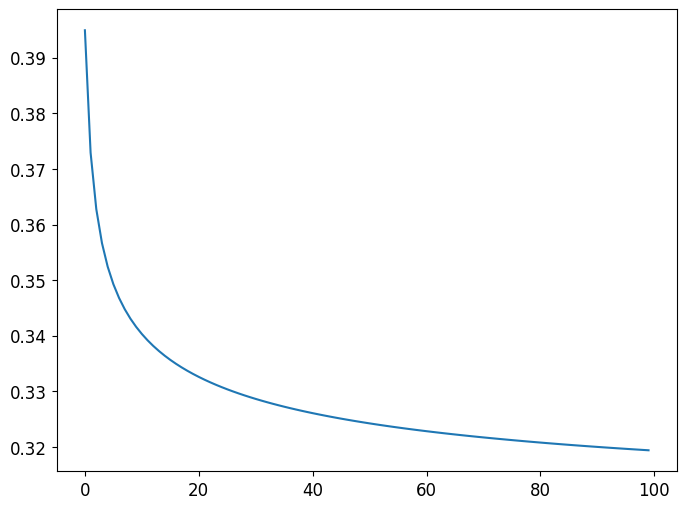

In [ ]:
plt.figure()
plt.plot(np.arange(iterations), Loss)
plt.grid = True
plt.xlabel = 'Iterations'
plt.ylabel = 'Loss'
plt.show()

In [ ]:
pipe_sgd_over[1] #Estimator since SGD is second element in pipeline

,loss,'log_loss'
,penalty,'l2'
,alpha,0
,l1_ratio,0.15
,fit_intercept,True
,max_iter,1
,tol,0.001
,shuffle,True
,verbose,0
,epsilon,0.1
,n_jobs,None


In [ ]:
y_hat = pipe_sgd_over.predict(X_test)

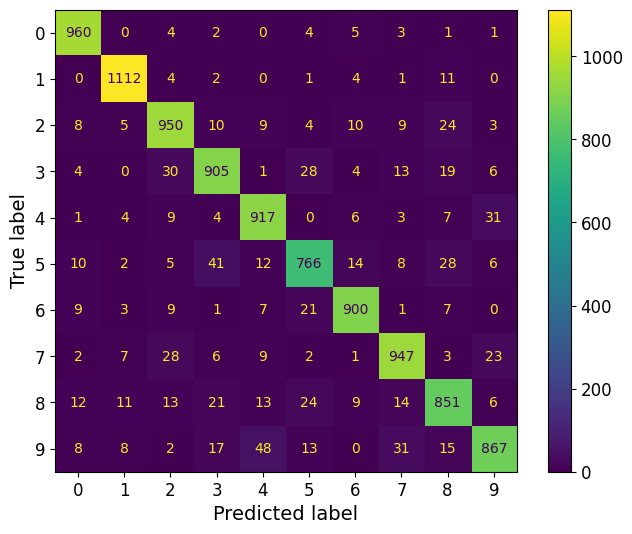

In [ ]:
cm_display = ConfusionMatrixDisplay.from_predictions(y_test, y_hat, values_format='0.5g')

In [ ]:
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       0.95      0.98      0.96       980
           1       0.97      0.98      0.97      1135
           2       0.90      0.92      0.91      1032
           3       0.90      0.90      0.90      1010
           4       0.90      0.93      0.92       982
           5       0.89      0.86      0.87       892
           6       0.94      0.94      0.94       958
           7       0.92      0.92      0.92      1028
           8       0.88      0.87      0.88       974
           9       0.92      0.86      0.89      1009

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



## Using SOLVERS in Logistic regression

In [ ]:
pipe_logit_ovr = make_pipeline(MinMaxScaler(), LogisticRegression(solver='lbfgs', random_state=42, C=np.inf))

pipe_logit_ovr.fit(X_train, y_train)

,steps,"[('minmaxscaler', ...), ('logisticregression', ...)]"
,transform_input,None
,memory,None
,verbose,False
,feature_range,"(0, ...)"
,copy,True
,clip,False
,penalty,'l2'
,dual,False
,tol,0.0001
,C,inf


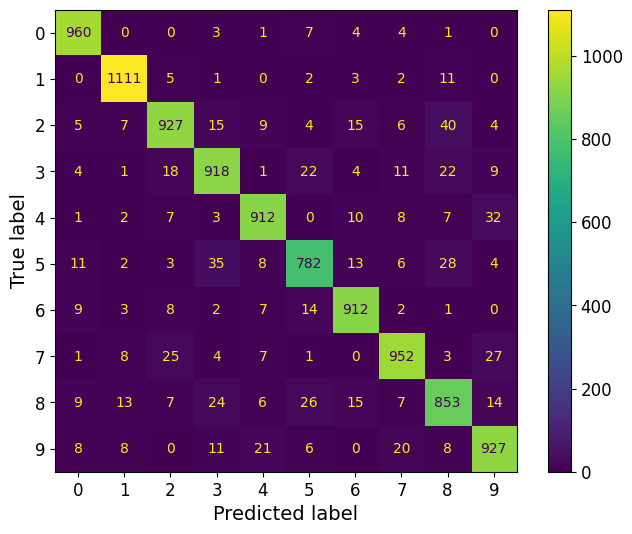

In [ ]:
y_hat = pipe_logit_ovr.predict(X_test)
cm_display = ConfusionMatrixDisplay.from_predictions(y_test, y_hat, values_format='0.5g')

In [ ]:
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       0.95      0.98      0.97       980
           1       0.96      0.98      0.97      1135
           2       0.93      0.90      0.91      1032
           3       0.90      0.91      0.91      1010
           4       0.94      0.93      0.93       982
           5       0.91      0.88      0.89       892
           6       0.93      0.95      0.94       958
           7       0.94      0.93      0.93      1028
           8       0.88      0.88      0.88       974
           9       0.91      0.92      0.92      1009

    accuracy                           0.93     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.93      0.93      0.93     10000



# Softmax Regression on MNIST

In [ ]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.preprocessing import StandardScaler

In [ ]:
pipe = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(multi_class='multinomial', solver='sag'))
])

pipe.fit(X_train, y_train)

,steps,"[('scaler', ...), ('logreg', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0


In [ ]:
print(classification_report(y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       0.95      0.98      0.97       980
           1       0.96      0.98      0.97      1135
           2       0.94      0.90      0.92      1032
           3       0.91      0.91      0.91      1010
           4       0.92      0.94      0.93       982
           5       0.91      0.87      0.89       892
           6       0.93      0.95      0.94       958
           7       0.92      0.93      0.92      1028
           8       0.88      0.88      0.88       974
           9       0.91      0.91      0.91      1009

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



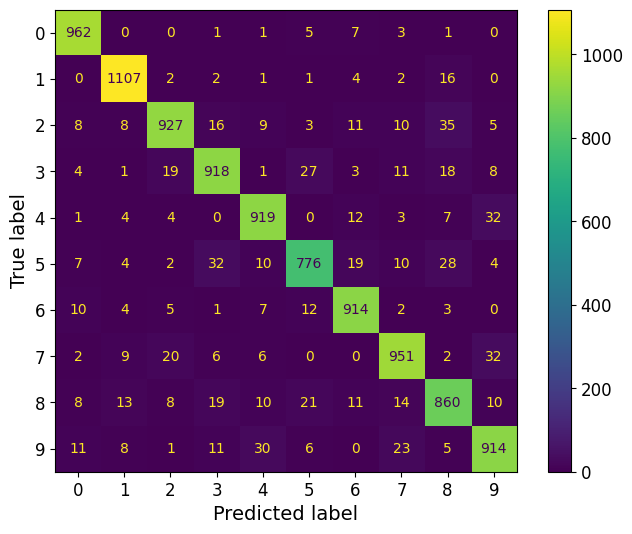

In [ ]:
ConfusionMatrixDisplay.from_estimator(pipe, X_test, y_test)

### Optimal value for C and l1

In [ ]:
from sklearn.metrics import f1_score

In [ ]:
# scorer = make_scorer(f1_score, average='micro')

# pipe = Pipeline(steps=[
#     ('scaler', StandardScaler()),
#     ('logreg', LogisticRegressionCV(
#         penalty='elasticnet',
#         solver='saga',
#         multi_class='multinomial',
#         scoring=scorer,
#         cv=5,
#         max_iter=100,
#         Cs=np.logspace(-4, 4, 10),     
#         l1_ratios=[0.1, 0.5, 0.9],        
#         random_state=1729))
# ])

# pipe.fit(X_train, y_train)

In [ ]:
# print(pipe[-1].C_)

# print(pipe[-1].l1_ratio_)

In [ ]:
# print (classification_report (y_test, pipe.predict(X_test)))

In [ ]:
# ConfusionMatrixDisplay.from_estimator(pipe, X_test, y_test)

## KNN with MNIST

In [ ]:
from sklearn.linear_model import Perceptron
from sklearn.decomposition import PCA
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import (
    cross_validate,
    RandomizedSearchCV,
    GridSearchCV,
    cross_val_predict,
    learning_curve
)
from matplotlib.colors import ListedColormap


### Feature Extraction

In [ ]:
pipe_pca_2d = make_pipeline(MinMaxScaler(), PCA(n_components=2))
x_train_pca_2d = pipe_pca_2d.fit_transform(X_train)

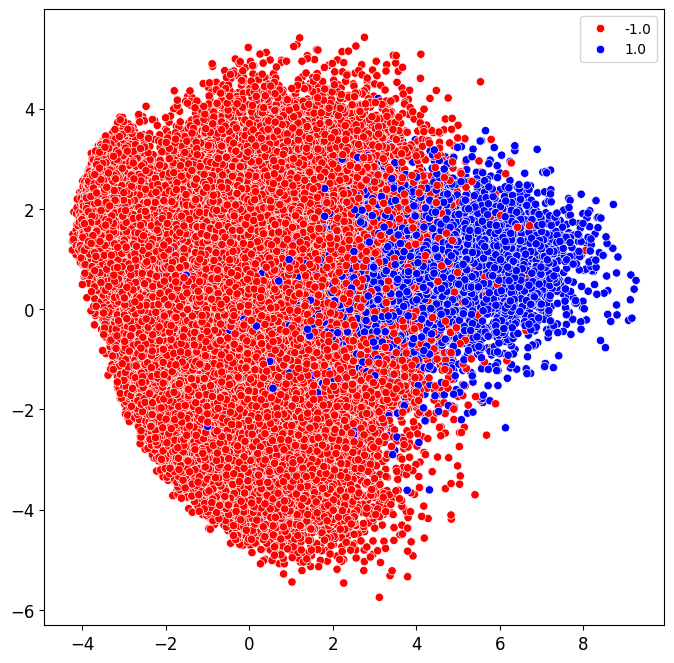

In [ ]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import seaborn as sns

cmap = ListedColormap(['r', 'b'])

plt.figure(figsize=(8, 8))
sns.scatterplot(
    x=x_train_pca_2d[:, 0],
    y=x_train_pca_2d[:, 1],
    hue=y_train_0,
    palette=cmap
)
plt.show()


In [ ]:
pipe_pca_3d = make_pipeline(MinMaxScaler(), PCA(n_components=3))
x_train_pca_3d = pipe_pca_3d.fit_transform(X_train)

In [ ]:
import plotly.io as pio
pio.renderers.default = "browser"
fig = px.scatter_3d(
    x=x_train_pca_3d[:, 0],
    y=x_train_pca_3d[:, 1],
    z=x_train_pca_3d[:, 2],
    color=y_train_0,
    opacity=0.5
)
fig.show()

### KNN Classifier

In [ ]:
pipe_clf_pca_2d = make_pipeline(pipe_pca_2d, KNeighborsClassifier(n_neighbors=3))

In [ ]:
index_neg = np.argsort(y_train_0)[:5]
index_pos = np.argsort(y_train_0)[-5:]

In [ ]:
print("Pos_classes:", y_train_0[index_pos])
print( "Neg classes:", y_train_0[index_neg])

Pos_classes: [1. 1. 1. 1. 1.]
Neg classes: [-1. -1. -1. -1. -1.]


In [ ]:
# Stack selected samples
x = np.vstack((
    X_train[index_pos, :],
    X_train[index_neg, :]
))
print(x.shape)   # (10, 784)

# Stack corresponding labels
y = np.hstack((
    y_train_0[index_pos],
    y_train_0[index_neg]
))
print(y.shape)   # (10,)


(10, 784)
(10,)


# SVC on MNIST

In [31]:
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import OrdinalEncoder
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from keras.datasets import mnist

In [32]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [33]:
X_train = X_train.reshape(X_train.shape[0], 28*28)
X_test = X_test.reshape(X_test.shape[0], 28*28)

In [34]:
X_train = X_train/255
X_test = X_test/255

In [35]:
X_train = X_train[0:10000,:]
y_train = y_train[0:10000]
X_test = X_test[0:2000, :]
y_test = y_test[0:2000]

## Linear SVM

In [ ]:
pipe_1 = Pipeline([
    ('scaler', MinMaxScaler()),
    ('classifer', SVC(kernel='linear', C=1))
])
pipe_1.fit(X_train, y_train.ravel())

,steps,"[('scaler', ...), ('classifer', ...)]"
,transform_input,None
,memory,None
,verbose,False
,feature_range,"(0, ...)"
,copy,True
,clip,False
,C,1
,kernel,'linear'
,degree,3
,gamma,'scale'


In [ ]:
acc = cross_val_score(pipe_1, X_train, y_train.ravel(), cv=2)
print(acc.mean()*100)

91.07000000000001


## Non-Linear SVC

In [ ]:
pipe_2 = Pipeline([
    ('scaler', MinMaxScaler()),
    ('classifer', SVC(kernel='rbf', C=1, gamma=0.1))
])
pipe_2.fit(X_train, y_train.ravel())

,steps,"[('scaler', ...), ('classifer', ...)]"
,transform_input,None
,memory,None
,verbose,False
,feature_range,"(0, ...)"
,copy,True
,clip,False
,C,1
,kernel,'rbf'
,degree,3
,gamma,0.1


In [ ]:
acc = cross_val_score(pipe_2, X_train, y_train.ravel(), cv=2)
print(acc.mean()*100)

82.87


## Using GridSearchCV

In [ ]:
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.fit_transform(X_test)
# C_range = np.logspace(-2, 10, 13)
# gamma_range = np.logspace(-9, 3, 13)

# param_grid = dict(gamma=gamma_range, C=C_range)
# cv = StratifiedShuffleSplit(n_splits=3, test_size=0.2, random_state=42)
# grid = GridSearchCV(SVC(kernel ='rbf'), param_grid=param_grid, cv=cv)
# grid.fit(X_train, y_train.ravel())
# print("The best parameters are %s with a score of %0.2f" %(grid.best_params_, grid.best_score_))

# Bagging and Random Forest on MNIST

In [41]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import ShuffleSplit, train_test_split, cross_validate, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

In [42]:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)

In [43]:
def train_classifiers(estimator, X_train, y_train, cv, name):
    estimator.fit(X_train, y_train)
    cv_train_score = cross_val_score(estimator, X_train, y_train, cv=cv, scoring='f1_macro')
    print (f"On an average, {name} model has fl score of "
    f"{cv_train_score.mean():.3f} +/- {cv_train_score.std():.3f} on the training set.")

In [46]:
def eval(estimator, X_test, y_test):
    y_pred = estimator.predict(X_test)
    print("# Classification report")
    print (classification_report(y_test, y_pred))
    print ("# Confusion matrix")
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred))
    disp.plot()
    plt.title('Confusion matrix')
    plt.show()

## Decision Tree

In [48]:
decision_tree_pipeline = Pipeline([
    ("classifier", DecisionTreeClassifier())
    ])
train_classifiers(decision_tree_pipeline, X_train, y_train.ravel(), cv, "decision tree")

On an average, decision tree model has fl score of 0.801 +/- 0.010 on the training set.


# Classification report
              precision    recall  f1-score   support

           0       0.81      0.87      0.84       175
           1       0.90      0.93      0.91       234
           2       0.77      0.74      0.76       219
           3       0.72      0.71      0.72       207
           4       0.75      0.75      0.75       217
           5       0.69      0.70      0.70       179
           6       0.81      0.74      0.78       178
           7       0.81      0.84      0.82       205
           8       0.64      0.60      0.62       192
           9       0.77      0.80      0.78       194

    accuracy                           0.77      2000
   macro avg       0.77      0.77      0.77      2000
weighted avg       0.77      0.77      0.77      2000

# Confusion matrix


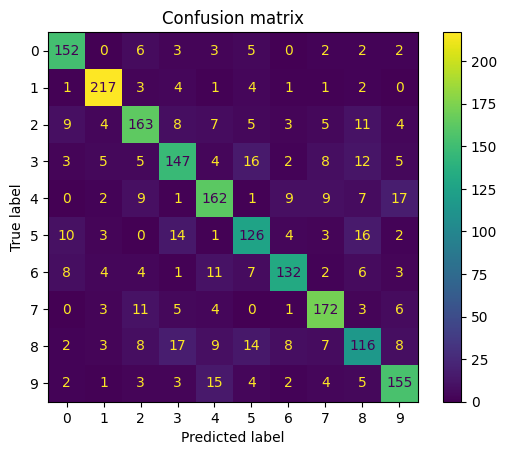

In [49]:
eval(decision_tree_pipeline, X_test, y_test)

## Bagging

In [50]:
bagging_pipeline = Pipeline([
    ("classifier", BaggingClassifier())])

train_classifiers(bagging_pipeline, X_train, y_train.ravel(), cv, "bagging" )

On an average, bagging model has fl score of 0.905 +/- 0.009 on the training set.


# Classification report
              precision    recall  f1-score   support

           0       0.87      0.98      0.92       175
           1       0.95      0.97      0.96       234
           2       0.83      0.85      0.84       219
           3       0.83      0.86      0.84       207
           4       0.87      0.87      0.87       217
           5       0.84      0.81      0.83       179
           6       0.92      0.90      0.91       178
           7       0.93      0.88      0.90       205
           8       0.84      0.77      0.80       192
           9       0.85      0.87      0.86       194

    accuracy                           0.87      2000
   macro avg       0.87      0.87      0.87      2000
weighted avg       0.87      0.87      0.87      2000

# Confusion matrix


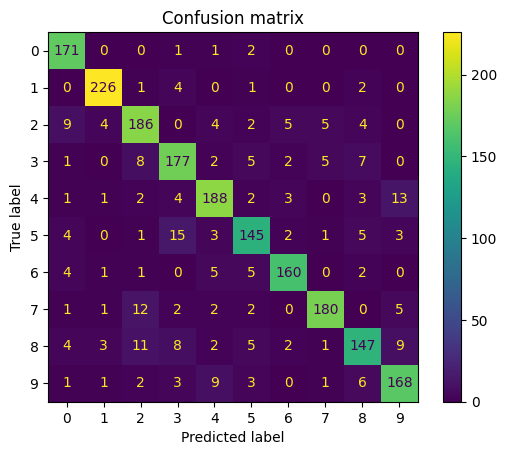

In [51]:
eval(bagging_pipeline, X_test, y_test)

## Random Forest

In [52]:
random_forest_pipeline = Pipeline([
    ("classifier", RandomForestClassifier())])

train_classifiers (random_forest_pipeline, X_train, y_train.ravel(), cv, "random forest")

On an average, random forest model has fl score of 0.944 +/- 0.004 on the training set.


# Classification report
              precision    recall  f1-score   support

           0       0.94      0.99      0.96       175
           1       0.98      0.99      0.99       234
           2       0.93      0.92      0.93       219
           3       0.92      0.91      0.91       207
           4       0.94      0.93      0.93       217
           5       0.94      0.91      0.92       179
           6       0.91      0.94      0.93       178
           7       0.93      0.89      0.91       205
           8       0.90      0.88      0.89       192
           9       0.87      0.91      0.89       194

    accuracy                           0.93      2000
   macro avg       0.93      0.93      0.93      2000
weighted avg       0.93      0.93      0.93      2000

# Confusion matrix


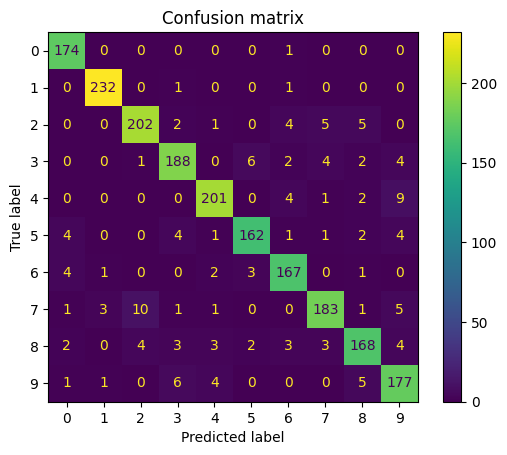

In [53]:
eval(random_forest_pipeline , X_test, y_test)

# AdaBoost, GradientBoost, Xgboost

## AdaBoost

In [56]:
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier

In [58]:
abc_pipeline = Pipeline([
    ('classifier', AdaBoostClassifier())
])

train_classifiers(abc_pipeline, X_train, y_train.ravel(), cv, "AdaBoost")

On an average, AdaBoost model has fl score of 0.644 +/- 0.017 on the training set.


# Classification report
              precision    recall  f1-score   support

           0       0.84      0.89      0.86       175
           1       0.93      0.88      0.90       234
           2       0.69      0.61      0.65       219
           3       0.47      0.76      0.58       207
           4       0.66      0.47      0.55       217
           5       0.65      0.33      0.44       179
           6       0.78      0.56      0.65       178
           7       0.46      0.84      0.60       205
           8       0.47      0.57      0.52       192
           9       0.67      0.30      0.41       194

    accuracy                           0.63      2000
   macro avg       0.66      0.62      0.62      2000
weighted avg       0.66      0.63      0.62      2000

# Confusion matrix


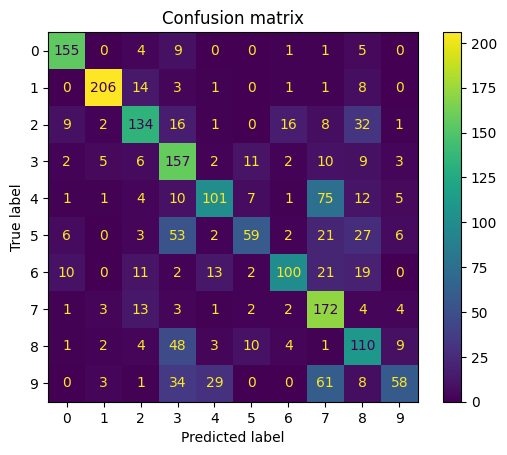

In [59]:
eval(abc_pipeline, X_test,y_test)

## GradientBoost

In [60]:
gbc_pipeline = Pipeline([
    ('classifier', GradientBoostingClassifier(n_estimators=10))
])

train_classifiers(gbc_pipeline, X_train, y_train.ravel(), cv, "GradientBoosting")


On an average, GradientBoosting model has fl score of 0.830 +/- 0.010 on the training set.


# Classification report
              precision    recall  f1-score   support

           0       0.84      0.93      0.89       175
           1       0.87      0.94      0.90       234
           2       0.80      0.77      0.79       219
           3       0.73      0.77      0.75       207
           4       0.77      0.80      0.78       217
           5       0.82      0.59      0.69       179
           6       0.88      0.69      0.77       178
           7       0.83      0.76      0.79       205
           8       0.65      0.67      0.66       192
           9       0.64      0.80      0.71       194

    accuracy                           0.78      2000
   macro avg       0.78      0.77      0.77      2000
weighted avg       0.78      0.78      0.78      2000

# Confusion matrix


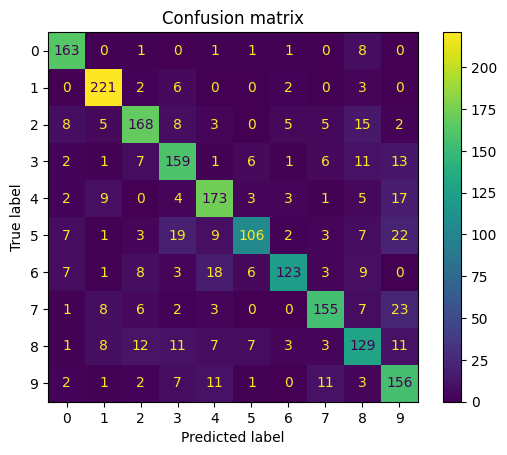

In [61]:
eval(gbc_pipeline, X_test,y_test)

## XGBoost

In [62]:
from xgboost import XGBClassifier

In [63]:
xbc_pipeline = Pipeline([
    ("classifier", XGBClassifier())
    ])

train_classifiers(xbc_pipeline, X_train, y_train.ravel(), cv, "GradientBoostingClassifier")

On an average, GradientBoostingClassifier model has fl score of 0.948 +/- 0.004 on the training set.


# Classification report
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       175
           1       0.98      0.98      0.98       234
           2       0.93      0.91      0.92       219
           3       0.94      0.92      0.93       207
           4       0.95      0.94      0.94       217
           5       0.95      0.94      0.95       179
           6       0.90      0.94      0.92       178
           7       0.93      0.89      0.91       205
           8       0.92      0.90      0.91       192
           9       0.91      0.95      0.93       194

    accuracy                           0.94      2000
   macro avg       0.94      0.94      0.94      2000
weighted avg       0.94      0.94      0.94      2000

# Confusion matrix


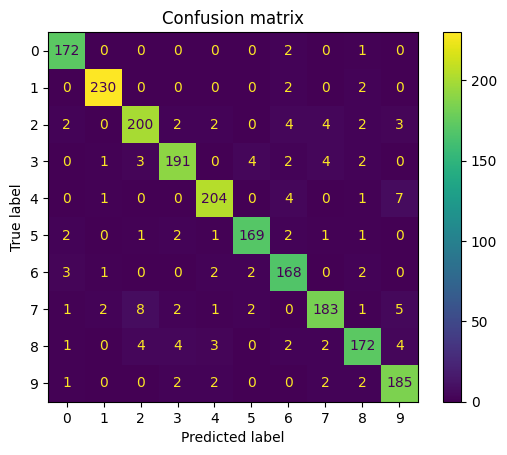

In [65]:
eval(xbc_pipeline, X_test,y_test)

# MLP(Neural Network) on MNIST

In [67]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

In [68]:
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

In [69]:
mlpc = MLPClassifier(hidden_layer_sizes=(128,))
mlpc.fit(X_train, y_train)

,hidden_layer_sizes,"(128,)"
,activation,'relu'
,solver,'adam'
,alpha,0.0001
,batch_size,'auto'
,learning_rate,'constant'
,learning_rate_init,0.001
,power_t,0.5
,max_iter,200
,shuffle,True
,random_state,None


In [70]:
cv_score = cross_val_score(mlpc, X_train, y_train.ravel(),cv=cv)
print("Training Accuracy: {:.2f}%".format(cv_score.mean()*100))

Training Accuracy: 94.96%


In [72]:
y_pred = mlpc.predict(X_test)

In [75]:
print("Train accuracy:{:.2f}%".format(accuracy_score(y_train, mlpc.predict(X_train))*100))
print ("Test accuracy:{:.2f}%".format(accuracy_score(y_test, y_pred) *100))

Train accuracy:100.00%
Test accuracy:94.50%


In [76]:
CR = classification_report(y_test, y_pred)
print('Classification report \n')
print(CR)

Classification report 

              precision    recall  f1-score   support

           0       0.96      0.99      0.97       175
           1       0.97      0.98      0.97       234
           2       0.95      0.96      0.96       219
           3       0.94      0.93      0.93       207
           4       0.95      0.94      0.95       217
           5       0.95      0.91      0.93       179
           6       0.92      0.94      0.93       178
           7       0.94      0.94      0.94       205
           8       0.94      0.93      0.93       192
           9       0.92      0.93      0.93       194

    accuracy                           0.94      2000
   macro avg       0.94      0.94      0.94      2000
weighted avg       0.95      0.94      0.94      2000

